In [76]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1.1 Reading Data

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

## Taking of fewwer datapoints

In [5]:
n = 5000

In [6]:
df = project_data.head(n)
df.shape

(5000, 17)

In [7]:
set(df['teacher_prefix'].values)

{'Mr.', 'Mrs.', 'Ms.', 'Teacher'}

In [8]:
df = df.append(project_data[project_data['teacher_prefix']=='Dr.'])
df.shape


(5013, 17)

In [9]:
col = list(df.columns)
col.remove('id')

df2 = pd.merge(df, resource_data,  how='left', left_on=['id'], right_on = ['id']).drop(col,axis = 1)
df2.shape

(29188, 4)

In [10]:
set(df['id'].values) == set(df2['id'].values)

True

In [11]:
project_data = df.copy()
resource_data = df2.copy()
project_data.shape,resource_data.shape

((5013, 17), (29188, 4))

## 1.2 Pre-processing of the data

### 1.2.1 Pre-processing of the sub-cateogry values

In [12]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in tqdm(catogories):
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)




100%|██████████████████████████████████████████████████████████████████████████| 5013/5013 [00:00<00:00, 198598.74it/s]


In [13]:
from collections import Counter
my_counter = Counter()
for word in tqdm(project_data['clean_categories'].values):
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

100%|██████████████████████████████████████████████████████████████████████████| 5013/5013 [00:00<00:00, 217069.94it/s]


### 1.2.2 preprocessing of `project_subject_subcategories`

In [14]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

### 1.2.3 Text preprocessing

In [15]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [16]:
# project_data.drop(['project_essay_1'], axis=1, inplace=True)
project_data.drop(['project_essay_2'], axis=1, inplace=True)
project_data.drop(['project_essay_3'], axis=1, inplace=True)
project_data.drop(['project_essay_4'], axis=1, inplace=True)

In [17]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  
0  My students are English learners that are work...  
1  Our students arrive to our school eager to lea...

In [18]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|████████████████████████████████████████████████████████████████████████████| 5013/5013 [00:04<00:00, 1189.20it/s]


In [21]:
project_data['essay'] = preprocessed_essays

<h2><font color='red'> 1.4 Preprocessing of `project_title`</font></h2>

In [22]:
# similarly you can preprocess the titles also
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|███████████████████████████████████████████████████████████████████████████| 5013/5013 [00:00<00:00, 23991.82it/s]


In [23]:
project_data['project_title'] = preprocessed_titles

### 1.4.1 Preprocessing of the teacher_prefix

In [24]:
project_data['teacher_prefix'].fillna("Others",inplace = True)
set(project_data['teacher_prefix'].values)

{'Dr.', 'Mr.', 'Mrs.', 'Ms.', 'Teacher'}

### 1.4.2 Preprocessing of the price

In [25]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

###  1.4.3 Preprocessing of the Project_grad

In [26]:
lst = list(project_data['project_grade_category'].values)
preprocessed_grades = []
for l in lst:
    l = l.replace('Grades ','Grades')
    l = l.replace('-','_')
    preprocessed_grades.append(l)
set(preprocessed_grades)

{'Grades3_5', 'Grades6_8', 'Grades9_12', 'GradesPreK_2'}

In [27]:
project_data['project_grade_category'] = preprocessed_grades
set(project_data['project_grade_category'].values)

{'Grades3_5', 'Grades6_8', 'Grades9_12', 'GradesPreK_2'}

## 1.5 Preparing data for models

In [28]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price',
       'quantity'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

In [29]:
y = project_data["project_is_approved"]
X = project_data.drop("project_is_approved",axis = 1)
X.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price', 'quantity'],
      dtype='object')

### 1.5.4 Numerical Variables

In [30]:
X.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price', 'quantity'],
      dtype='object')

In [31]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X['price'].values.reshape(1,-1))

X_price_norm = normalizer.transform(X['price'].values.reshape(1,-1))

print("After vectorizations")
print(X_price_norm.shape, y.shape)

After vectorizations
(1, 5013) (5013,)


In [32]:
normalizer = Normalizer()

normalizer.fit(X['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_tnopp_norm = normalizer.transform(X['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

print("After vectorizations")
print(X_tnopp_norm.shape, y.shape)
print("="*100)

After vectorizations
(1, 5013) (5013,)


## Categorical Features

In [33]:
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(X['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_school_ohe = vectorizer.transform(X['school_state'].values)

print("After One Hot encoding")
print(X_school_ohe.shape, y.shape)
print("="*100)
school_state_features = vectorizer.get_feature_names()

After One Hot encoding
(5013, 48) (5013,)


In [34]:
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(X['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_clean_categories_ohe = vectorizer.transform(X['clean_categories'].values)

print("After One Hot encoding")
print(X_clean_categories_ohe.shape, y.shape)
print("="*100)
clean_categories_features = vectorizer.get_feature_names()

After One Hot encoding
(5013, 9) (5013,)


In [35]:
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(X['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_clean_subcategories_ohe = vectorizer.transform(X['clean_subcategories'].values)

print("After One Hot encoding")
print(X_clean_subcategories_ohe.shape, y.shape)
print("="*100)
clean_subcategories_features = vectorizer.get_feature_names()



After One Hot encoding
(5013, 30) (5013,)


In [36]:
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(X['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_project_grade_category_ohe = vectorizer.transform(X['project_grade_category'].values)

print("After One Hot encoding")
print(X_project_grade_category_ohe.shape, y.shape)
print("="*100)
project_grade_category_features = vectorizer.get_feature_names()
print(project_grade_category_features)



After One Hot encoding
(5013, 4) (5013,)
['grades3_5', 'grades6_8', 'grades9_12', 'gradesprek_2']


In [37]:
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(X['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_teacher_prefix_ohe = vectorizer.transform(X['teacher_prefix'].values)

print("After One Hot encoding")
print(X_teacher_prefix_ohe.shape, y.shape)
print("="*100)
teacher_prefix_category_features = vectorizer.get_feature_names()


After One Hot encoding
(5013, 5) (5013,)


### Vectorizing Text Data : BOW Vectorizations

In [38]:
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(X['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_essay_bow = vectorizer.transform(X['essay'].values)

print("After vectorizations")
print(X_essay_bow.shape, y.shape)
print("="*100)
essay_bow_features = vectorizer.get_feature_names()


After vectorizations
(5013, 4304) (5013,)


In [39]:
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(X['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_title_bow = vectorizer.transform(X['project_title'].values)

print("After vectorizations")
print(X_title_bow.shape, y.shape)
print("="*100)
title_bow_features = vectorizer.get_feature_names()

After vectorizations
(5013, 333) (5013,)


## 2.Selecting the best 5k features

In [40]:
print(X_essay_bow.shape)
print(X_title_bow.shape)
print(X_school_ohe.shape)
print(X_clean_categories_ohe.shape)
print(X_clean_subcategories_ohe.shape)
print(X_project_grade_category_ohe.shape)
print(X_teacher_prefix_ohe.shape)
print(X_price_norm.shape)
print(X_tnopp_norm.shape)


(5013, 4304)
(5013, 333)
(5013, 48)
(5013, 9)
(5013, 30)
(5013, 4)
(5013, 5)
(1, 5013)
(1, 5013)


In [41]:
X_price_norm = X_price_norm.T
X_tnopp_norm = X_tnopp_norm.T

In [42]:
from scipy.sparse import hstack


X_tr = hstack((X_essay_bow, X_title_bow,X_school_ohe, X_clean_categories_ohe,X_clean_subcategories_ohe,X_project_grade_category_ohe , X_teacher_prefix_ohe, X_price_norm, X_tnopp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y.shape)
print("="*100)

Final Data matrix
(5013, 4735) (5013,)


In [43]:
from sklearn.feature_selection import SelectKBest, chi2

vect = SelectKBest(chi2,k = 'all')
vect.fit(X_tr,y)

X_5k = vect.transform(X_tr)

print("Final Data matrix")
print(X_5k.shape, y.shape)
print("="*100)

Final Data matrix
(5013, 4735) (5013,)


# 3. Applying Algorithms

## 3.1 Applying K-Means Algo

In [117]:
# Ref : https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

distortions = []
for i in tqdm(range(1, 10)):
    km = KMeans(n_clusters=i)
    km.fit(X_5k)
    distortions.append(km.inertia_)
# Plot the elbow


100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [17:07<00:00, 135.09s/it]

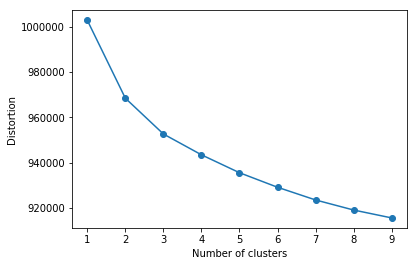

In [118]:
plt.plot(range(1, 10), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [45]:
best_k = 2

In [61]:
# Ref : https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

km = KMeans(n_clusters=best_k)
pred = km.fit_predict(X_5k)
len(km.labels_)

5013

**Since we got 2 cluster above, we'll have to plot the wordcloud of both cluster 0 and cluster 1**

### 3.1.1 Wordcloud of cluster 0

In [ ]:
essay_0 = ""
essay_1 = ""
essays = X['essay'].values.tolist()
for i in range(0,len(km.labels_)):
    if(km.labels_[i] == 0):
        essay_0 = essay_0 + " "+essays[i]
        continue
    essay_1 = essay_1 + " "+essays[i]

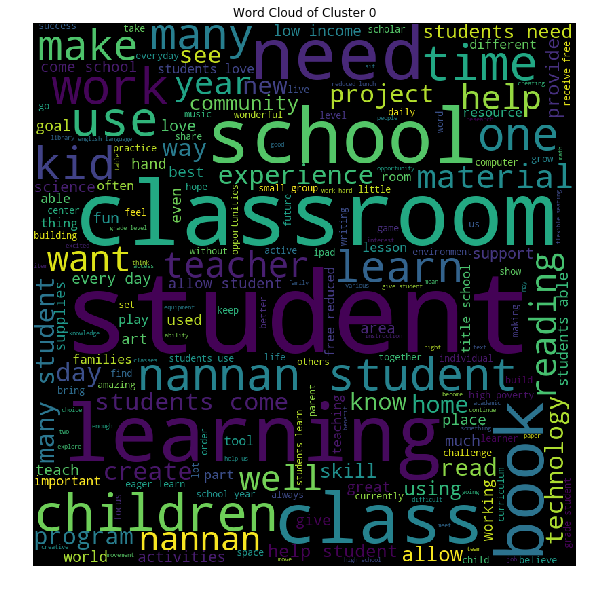

In [69]:
wordcloud = WordCloud(width = 800, height = 800).generate(essay_0) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.title("Word Cloud of Cluster 0")
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### 3.2.2 Word Cloud of cluster 2

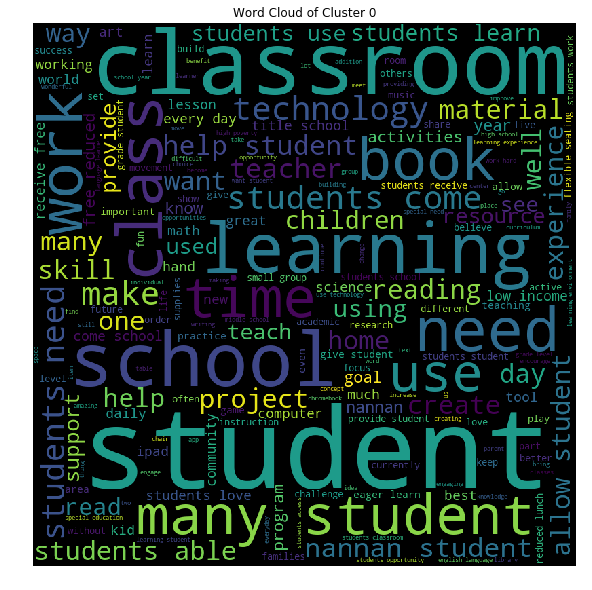

In [70]:
wordcloud = WordCloud(width = 800, height = 800).generate(essay_1) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.title("Word Cloud of Cluster 0")
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## Agglomerative Algorithm 2 Clusters

In [71]:
# Ref : https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/

from sklearn.cluster import AgglomerativeClustering
from time import time
dense_arr = X_5k.toarray()
start =time()
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
pred = cluster.fit_predict(dense_arr)  
end = time()
print (str(int((end-start)/60)))


1


### 3.2.1 Wordcloud of cluster 0

In [72]:
essay_0 = ""
essay_1 = ""
essays = X['essay'].values.tolist()
for i in range(0,len(cluster.labels_)):
    if(km.labels_[i] == 0):
        essay_0 = essay_0 + " "+essays[i]
        continue
    essay_1 = essay_1 + " "+essays[i]

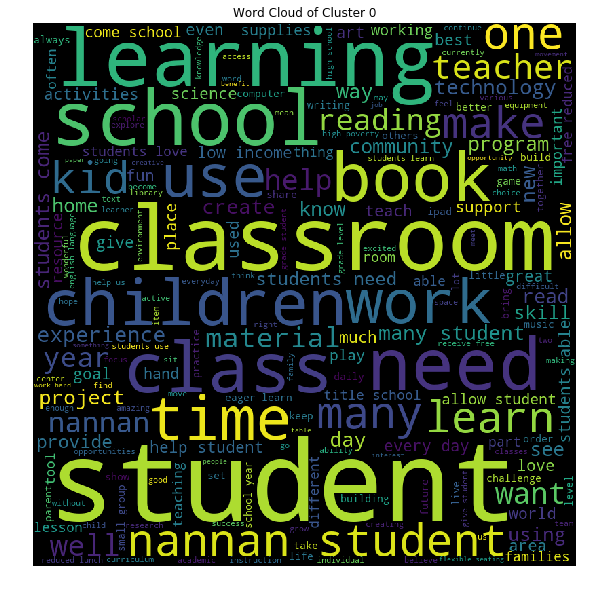

In [73]:
wordcloud = WordCloud(width = 800, height = 800).generate(essay_0) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.title("Word Cloud of Cluster 0")
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### 3.1.2 Word Cloud of cluster 2

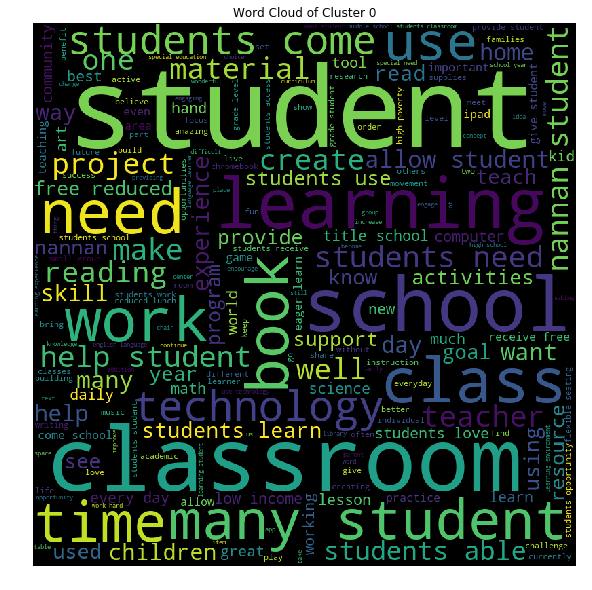

In [74]:
wordcloud = WordCloud(width = 800, height = 800).generate(essay_1) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.title("Word Cloud of Cluster 0")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Agglomorative CLustering with 4 clusters

In [75]:
# Ref : https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/

from sklearn.cluster import AgglomerativeClustering
from time import time
dense_arr = X_5k.toarray()
start =time()
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
pred = cluster.fit_predict(dense_arr)  
end = time()
print (str(int((end-start)/60)))


1


In [83]:
len(cluster.labels_)

5013

### 3.2.1 Wordcloud of cluster 0

In [89]:
essay_0 = ""
essay_1 = ""
essay_2 = ""
essay_3 = ""
essays = X['essay'].values.tolist()
for i in range(0,len(cluster.labels_)):
    if(cluster.labels_[i] == 0):
        essay_0 = essay_0 + " "+essays[i]
        continue
    if(cluster.labels_[i] == 2):
        essay_2 = essay_2 + " "+essays[i]
        continue
    if(cluster.labels_[i] == 3):
        essay_3 = essay_3 + " "+essays[i]
        continue
    essay_1 = essay_1 + " "+essays[i]

3483436 513555 534344 583426


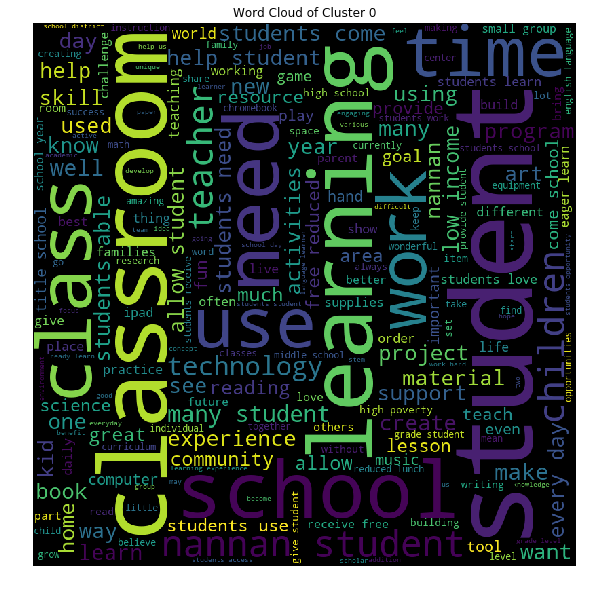

In [90]:
wordcloud = WordCloud(width = 800, height = 800).generate(essay_0) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.title("Word Cloud of Cluster 0")
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### 3.1.2 Word Cloud of cluster 1

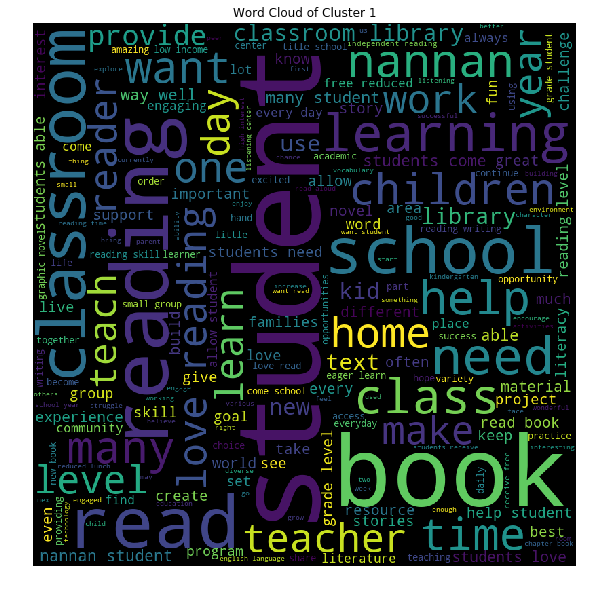

In [91]:
wordcloud = WordCloud(width = 800, height = 800).generate(essay_1) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.title("Word Cloud of Cluster 1")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### 3.1.2 Word Cloud of cluster 2

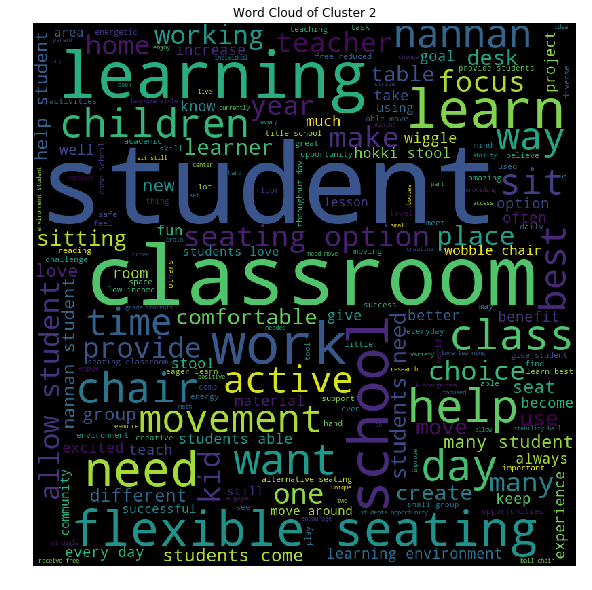

In [92]:
wordcloud = WordCloud(width = 800, height = 800).generate(essay_2) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.title("Word Cloud of Cluster 2")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### 3.1.2 Word Cloud of cluster 3

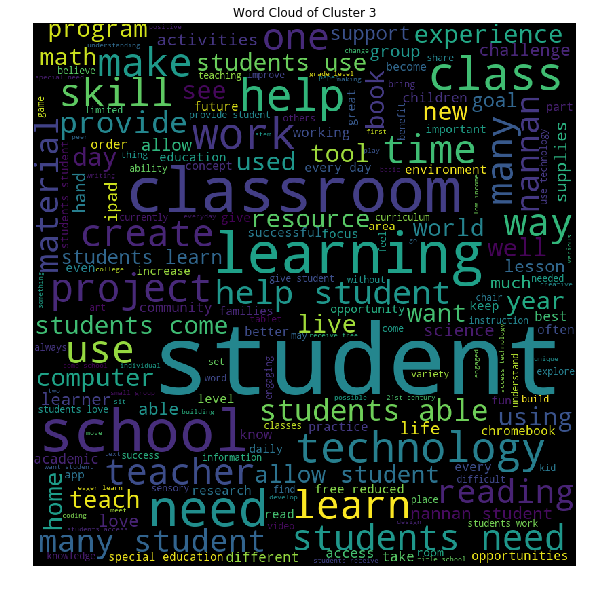

In [94]:
wordcloud = WordCloud(width = 800, height = 800).generate(essay_3) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.title("Word Cloud of Cluster 3")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Agglomorative CLustering with 6 clusters

In [95]:
# Ref : https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/

from sklearn.cluster import AgglomerativeClustering
from time import time
dense_arr = X_5k.toarray()
start =time()
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')  
pred = cluster.fit_predict(dense_arr)  
end = time()
print (str(int((end-start)/60)))


1


In [96]:
len(cluster.labels_)

5013

### 3.2.1 Wordcloud of cluster 0

In [97]:
essay_0 = ""
essay_1 = ""
essay_2 = ""
essay_3 = ""
essay_4 = ""
essay_5 = ""
essays = X['essay'].values.tolist()
for i in range(0,len(cluster.labels_)):
    if(cluster.labels_[i] == 0):
        essay_0 = essay_0 + " "+essays[i]
        continue
    if(cluster.labels_[i] == 2):
        essay_2 = essay_2 + " "+essays[i]
        continue
    if(cluster.labels_[i] == 3):
        essay_3 = essay_3 + " "+essays[i]
        continue
    if(cluster.labels_[i] == 4):
        essay_4 = essay_4 + " "+essays[i]
        continue
    if(cluster.labels_[i] == 5):
        essay_5 = essay_5 + " "+essays[i]
        continue
    essay_1 = essay_1 + " "+essays[i]

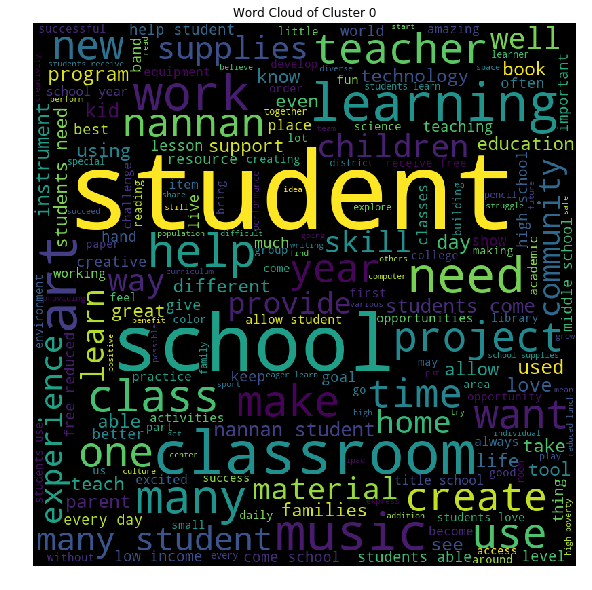

In [98]:
wordcloud = WordCloud(width = 800, height = 800).generate(essay_0) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.title("Word Cloud of Cluster 0")
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### 3.1.2 Word Cloud of cluster 1

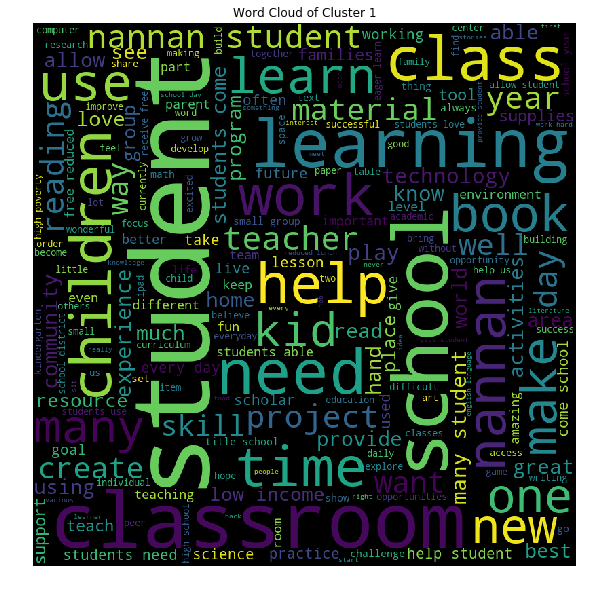

In [99]:
wordcloud = WordCloud(width = 800, height = 800).generate(essay_1) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.title("Word Cloud of Cluster 1")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### 3.1.2 Word Cloud of cluster 2

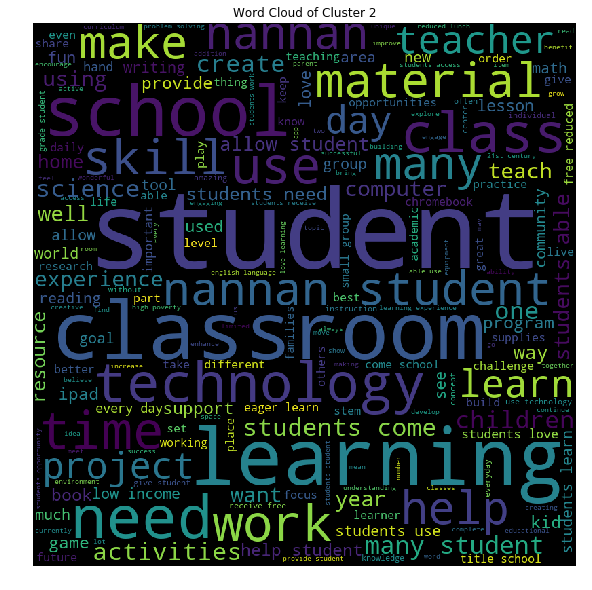

In [100]:
wordcloud = WordCloud(width = 800, height = 800).generate(essay_2) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.title("Word Cloud of Cluster 2")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### 3.1.2 Word Cloud of cluster 3

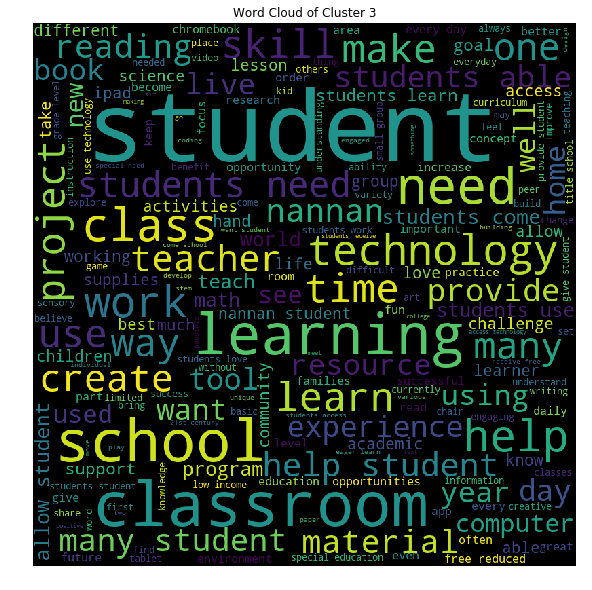

In [101]:
wordcloud = WordCloud(width = 800, height = 800).generate(essay_3) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.title("Word Cloud of Cluster 3")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### 3.1.2 Word Cloud of cluster 4

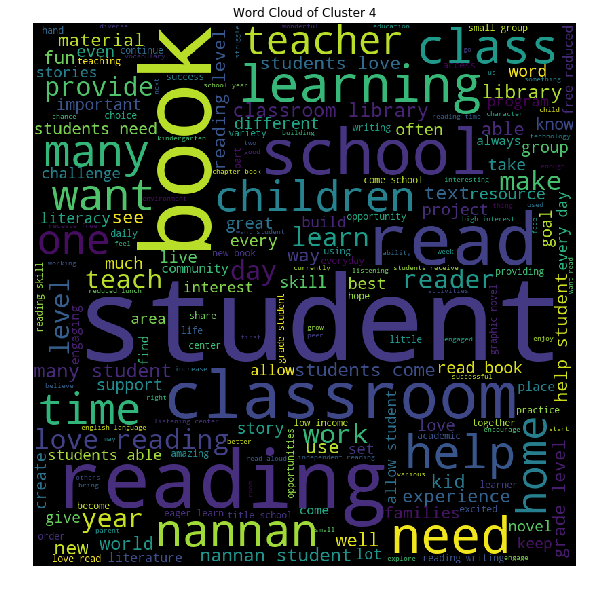

In [102]:
wordcloud = WordCloud(width = 800, height = 800).generate(essay_4) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.title("Word Cloud of Cluster 4")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### 3.1.2 Word Cloud of cluster 5

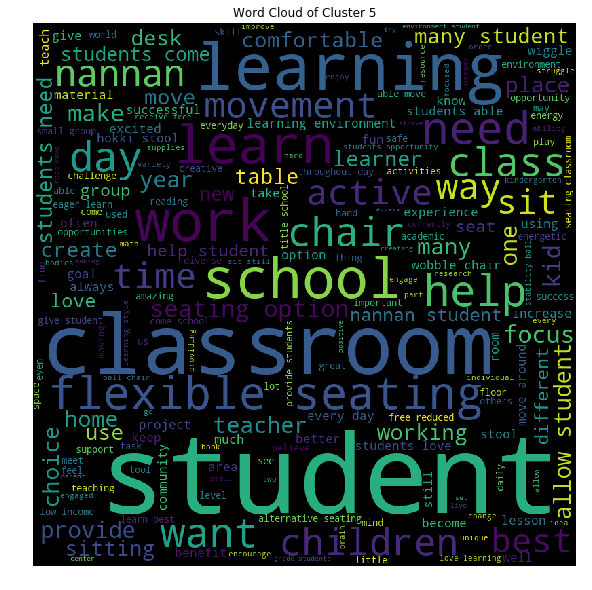

In [103]:
wordcloud = WordCloud(width = 800, height = 800).generate(essay_5) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.title("Word Cloud of Cluster 5")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# 3.3 DBSCAN Clustering

In [98]:
from sklearn.neighbors import NearestNeighbors

ns = 2
nbrs = NearestNeighbors(n_neighbors=ns).fit(X_5k)
distances, indices = nbrs.kneighbors(X_5k)


In [99]:
print(len(distances),len(indices),len(distanceDec))

5013 5013 5013


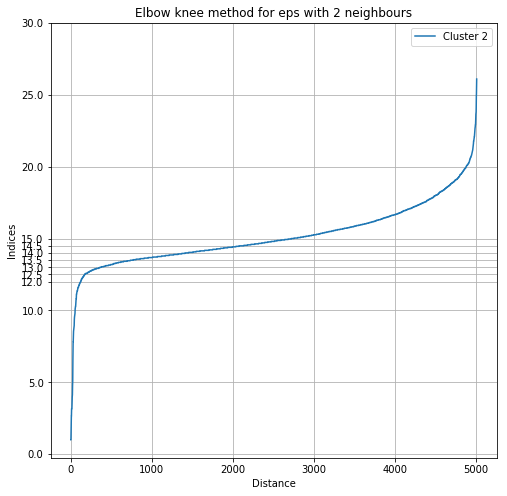

In [100]:
distanceDec_1 = sorted(distances[:,ns-2], reverse=False)
distanceDec_2 = sorted(distances[:,ns-1], reverse=False)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.plot(list(range(1,len(distances)+1)), distanceDec_2,label = "Cluster 2")
plt.grid()
plt.xlabel("Distance")
plt.ylabel("Indices")
plt.title("Elbow knee method for eps with 2 neighbours")
plt.legend()
plt.yticks([0,5,10,12,12.5,13,13.5,14,14.5,15,20,25,30])
plt.show()

In [101]:
ns = 3
nbrs = NearestNeighbors(n_neighbors=ns).fit(X_5k)
distances, indices = nbrs.kneighbors(X_5k)


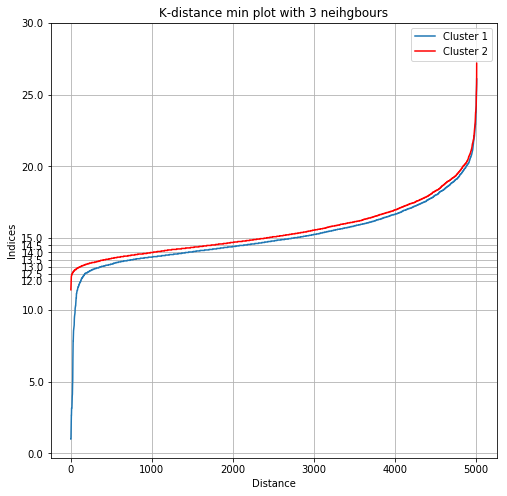

In [102]:
distanceDec_1 = sorted(distances[:,ns-2], reverse=False)
distanceDec_2 = sorted(distances[:,ns-1], reverse=False)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.plot(list(range(1,len(distances)+1)), distanceDec_1,label = "Cluster 1")
plt.plot(list(range(1,len(distances)+1)), distanceDec_2,label = "Cluster 2",c = "Red")
plt.grid()
plt.xlabel("Distance")
plt.ylabel("Indices")
plt.title("K-distance min plot with 3 neihgbours")
plt.legend()
plt.yticks([0,5,10,12,12.5,13,13.5,14,14.5,15,20,25,30])
plt.show()

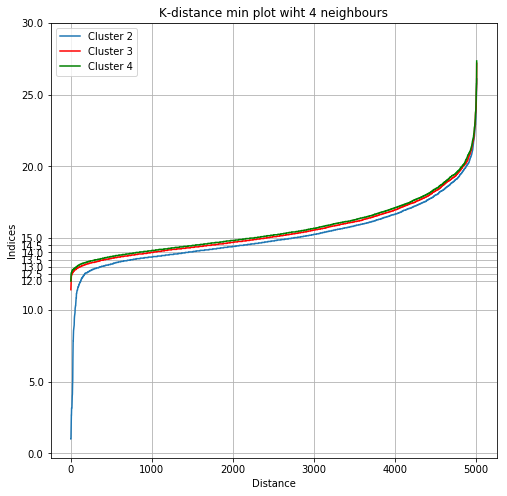

In [103]:
ns = 4
nbrs = NearestNeighbors(n_neighbors=ns).fit(X_5k)
distances, indices = nbrs.kneighbors(X_5k)

distanceDec_1 = sorted(distances[:,ns-3], reverse=False)
distanceDec_2 = sorted(distances[:,ns-2], reverse=False)
distanceDec_3 = sorted(distances[:,ns-1], reverse=False)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.plot(list(range(1,len(distances)+1)), distanceDec_1,label = "Cluster 2")
plt.plot(list(range(1,len(distances)+1)), distanceDec_2,label = "Cluster 3",c = "Red")
plt.plot(list(range(1,len(distances)+1)), distanceDec_3,label = "Cluster 4",c = "Green")
plt.grid()
plt.xlabel("Distance")
plt.ylabel("Indices")
plt.title("K-distance min plot wiht 4 neighbours")
plt.legend()
plt.yticks([0,5,10,12,12.5,13,13.5,14,14.5,15,20,25,30])
plt.show()


In [104]:
best_eps = 12.5

In [105]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=12.5).fit(X_5k)
labels = db.labels_

In [106]:
set(labels)

{-1, 0, 1, 2}

### Word Cloud

In [92]:
noise = ""
essay_0 = ""
essay_1 = ""
essay_2 = ""
count = 1 
essays = X['essay'].values.tolist()
for i in range(0,len(labels)):
    if labels[i] == -1:
        noise = noise + essays[i]
    elif labels[i] == 0:
        essay_0 = essay_0 + essays[i]
    elif labels[i] == 1:
        essay_1 = essay_1 + essays[i]
    elif labels[i] == 2:
        essay_2 = essay_2 + essays[i]
        

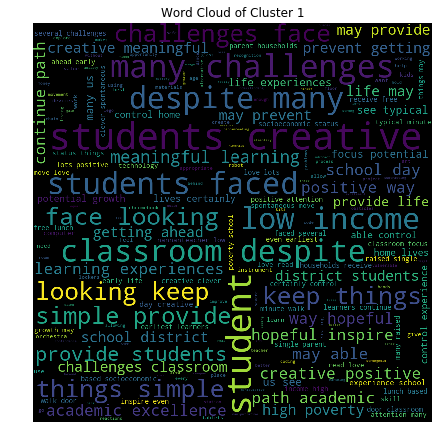

In [82]:
wordcloud = WordCloud(width = 800, height = 800).generate(essay_0) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.title("Word Cloud of Cluster 1")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

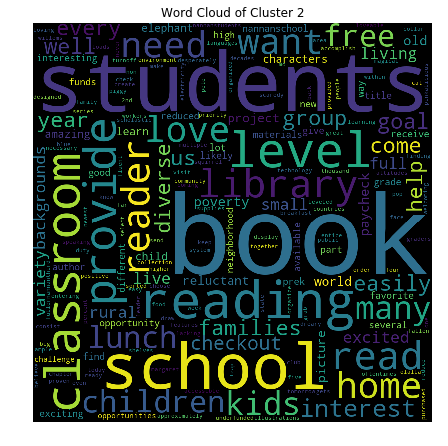

In [83]:
wordcloud = WordCloud(width = 800, height = 800).generate(essay_1) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.title("Word Cloud of Cluster 2")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

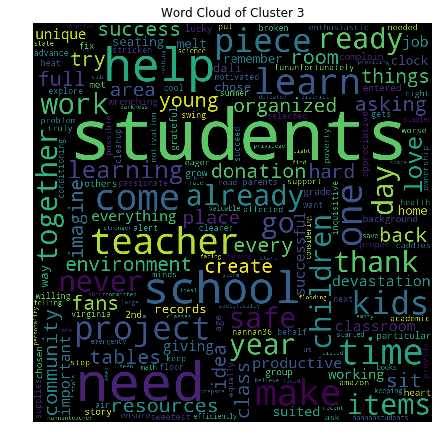

In [84]:
wordcloud = WordCloud(width = 800, height = 800).generate(essay_2) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.title("Word Cloud of Cluster 3")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

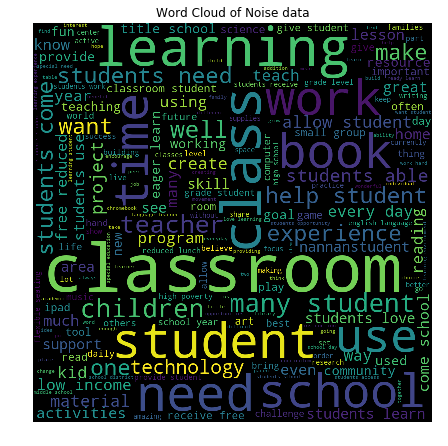

In [94]:
wordcloud = WordCloud(width = 800, height = 800).generate(noise) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.title("Word Cloud of Noise data")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Conclusions

**K-Means Clustering**

1. In K-means clustering when we used the elbow knee method we could clearly observe the knee at cluster = 2. So we consider the cluster number to be 2 itself
2. From the word Cloud of the cluster 1 we could observe that the the words classroom ,school ,student , learning are the frequent words which are repeatedly mostly
3. From the word Cloud of the cluster 2 we could observe that the the words student ,classroom ,school , learning are the frequent words which are repeatedly mostly

**Agglomerative Clustering**

1. In this clustering, we have tried with the 2,4 and 6 clusters
2. We could oberve that for n_cluster = 2, classroom, student are the most frequent words in both the clusters while in cluster 1 learning, school are also very frequent
3. We could observe that for n_cluster = 4, classroom and learning are most frequent words for cluster 1 and 3 while for the cluster student, book is the more frequent words while in the cluster 4, there are many other frequent words among which student stands at the top
4. We could observe that for n_cluster = 6, student is the most frequent word for all the clusters followed by the clasroom

**DBSCAN Clustering**

1. In the DBSCAN algorithm, we used the elbow knee method to find the eps(epsilon). We have tried with the 2,3 and 4 neighbors and we found the knee point at the distance of 12.5 and hence we have taken the eps = 12.5
2. After applying the DBSCAN we got the 3 clusters and the noisy datapoints
3. Noisy datapoints are represented by the -1 in the labels
4. In the cluster 1, there are many frequent words with student top among them
5. In the cluster 2, the words students,books,school are the frequent words
6. In the cluster 3, the word students is the most frequent word
 and there are many other frequent words and we can observe them in the word cloud
7. In the nosiy cluster we cloud observe that the noise is created by the classroom, learning suprisingly as they are the most frequent words for the agglomerative and the k_means clustering